# Optimization code with binary variables on consumers

In [14]:
import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import random

Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users_Complete"
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'
results_dir_ = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir_, datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '_BinaryConsumption')
os.makedirs(results_dir, exist_ok=True)
plot_dir = os.path.join(results_dir,'Plot')
economic_analysis_dir = os.path.join(results_dir,'Economic Analysis Plot')
yearly_plot_dir = os.path.join(plot_dir,'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir,'Weekly_Plot')
os.makedirs(yearly_plot_dir, exist_ok=True)
os.makedirs(weekly_plot_dir, exist_ok=True)
os.makedirs(economic_analysis_dir, exist_ok=True)

In [15]:
# Load user complete data
Residential_user_complete_df = pd.read_csv(os.path.join(Data_path_Users, 'DF_User_Residential_Complete.csv'))
Commercial_user_complete_df = pd.read_csv(os.path.join(Data_path_Users, 'DF_User_Commercial_Complete.csv'))
Industrial_user_complete_df = pd.read_csv(os.path.join(Data_path_Users, 'DF_User_Industrial_Complete.csv'))

# Load New Consumption Curves
Residential_user_Consumption = pd.read_csv(r'C:\Users\Nik\Desktop\Backup thesis\Consumption\ResidentialConsumption-4000\Modified_Residential_Consumption.csv', index_col=0, parse_dates=True)
Industrial_user_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Industrial_Consumption.csv', index_col=0, parse_dates=True)
Commercial_user_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Commercial_Consumption.csv', index_col=0, parse_dates=True)

# Filter Residential_user_complete_df to keep only rows where full_id matches columns in Residential_Consumption_df
Residential_user_complete_df_filtered = Residential_user_complete_df[Residential_user_complete_df['full_id'].isin(Residential_user_Consumption.columns)]

# Save the filtered data back to CSV
output_file = os.path.join(results_dir, 'Filtered_DF_User_Residential_Complete.csv')
Residential_user_complete_df_filtered.to_csv(output_file, index=False)
print(f"Filtered Residential users saved in: {output_file}")

Filtered Residential users saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Filtered_DF_User_Residential_Complete.csv


In [16]:
def sample_and_save(df, file_name, sample_size, results_dir):
    """
    Function to extract a random sample of rows from a DataFrame and save it to a CSV file.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to sample from.
    file_name (str): The name of the output file.
    sample_size (int): The number of random rows to extract.
    results_dir (str): The directory where the output file should be saved.
    """
    # Filter rows where "Area" is not NaN
    df_filtered = df.dropna(subset=['Area'])
    
    # Randomly select the specified number of rows if available, otherwise take all
    sample_size = min(sample_size, len(df_filtered))
    df_sample = df_filtered.sample(n=sample_size, random_state=42)  # Random state for reproducibility
    
    # Save the result in a new CSV file
    output_file = os.path.join(results_dir, f'sample_{file_name}')
    df_sample.to_csv(output_file, index=False)
    print(f"Sample saved in: {output_file}")

# Define the number of rows to sample for each dataset
sample_sizes = {
    'DF_User_Residential_Complete.csv': 50,
    'DF_User_Commercial_Complete.csv': 5,
    'DF_User_Industrial_Complete.csv': 2
}

# Process each dataset separately
for file_name, df in zip(
    ['DF_User_Residential_Complete.csv', 'DF_User_Commercial_Complete.csv', 'DF_User_Industrial_Complete.csv'],
    [Residential_user_complete_df_filtered, Commercial_user_complete_df, Industrial_user_complete_df]
):
    sample_size = sample_sizes.get(file_name, 10)  # Default to 10 if not specified
    sample_and_save(df, file_name, sample_size, results_dir)


Sample saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\sample_DF_User_Residential_Complete.csv
Sample saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\sample_DF_User_Commercial_Complete.csv
Sample saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\sample_DF_User_Industrial_Complete.csv


In [17]:
Residential_user_Production = pd.read_csv(r'C:\Users\Nik\Desktop\Backup thesis\Consumption\ResidentialConsumption-4000\Modified_Residential_Production.csv', sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_Production = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_Production = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Load New Consumption Curves
Residential_user_Consumption = pd.read_csv(r'C:\Users\Nik\Desktop\Backup thesis\Consumption\ResidentialConsumption-4000\Modified_Residential_Consumption.csv', index_col=0, parse_dates=True)
Industrial_user_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Industrial_Consumption.csv', index_col=0, parse_dates=True)
Commercial_user_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Commercial_Consumption.csv', index_col=0, parse_dates=True)


## Filtering chosen users' production curves

In [18]:
# List of user sample files
sample_files = [
    'sample_DF_User_Residential_Complete.csv',
    'sample_DF_User_Commercial_Complete.csv',
    'sample_DF_User_Industrial_Complete.csv'
]

# Corresponding production file names
production_files = [
    Residential_user_Production,
    Commercial_user_Production,
    Industrial_user_Production
]

# Corresponding output file names
output_files = [
    'Chosen_Residential_Production.csv',
    'Chosen_Commercial_Production.csv',
    'Chosen_Industrial_Production.csv'
]

# Extract relevant columns from production tables
for sample_file, df_production, output_file in zip(sample_files, production_files, output_files):
    sample_path = os.path.join(results_dir, sample_file)
    
    if os.path.exists(sample_path):
        df_sample = pd.read_csv(sample_path)
        
        if 'full_id' not in df_sample.columns:
            print(f"Warning: 'full_id' column not found in {sample_file}. Skipping file.")
            continue
        
        # Select only columns in df_production that match full_id rows in df_sample
        matching_columns = [col for col in df_production.columns if col in df_sample['full_id'].values]
        
        if not matching_columns:
            print(f"Warning: No matching columns found for {sample_file}. Skipping file.")
            continue
        
        df_selected = df_production[matching_columns]
        
        # Save the extracted data back to CSV
        output_path = os.path.join(results_dir, output_file)
        df_selected.to_csv(output_path, index=False)
        print(f"Chosen production data saved in: {output_path}")

Chosen production data saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Chosen_Residential_Production.csv
Chosen production data saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Chosen_Commercial_Production.csv
Chosen production data saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Chosen_Industrial_Production.csv


## Filtering chosen users' consumption curves

In [19]:
# List of user sample files
sample_files = [
    'sample_DF_User_Residential_Complete.csv',
    'sample_DF_User_Commercial_Complete.csv',
    'sample_DF_User_Industrial_Complete.csv'
]

# Corresponding production file names
consumption_files = [
    Residential_user_Consumption,
    Commercial_user_Consumption,
    Industrial_user_Consumption
]

# Corresponding output file names
output_files = [
    'Chosen_Residential_Consumption.csv',
    'Chosen_Commercial_Consumption.csv',
    'Chosen_Industrial_Consumption.csv'
]

# Extract relevant columns from production tables
for sample_file, df_consumption, output_file in zip(sample_files, consumption_files, output_files):
    sample_path = os.path.join(results_dir, sample_file)
    
    if os.path.exists(sample_path):
        df_sample = pd.read_csv(sample_path)
        
        if 'full_id' not in df_sample.columns:
            print(f"Warning: 'full_id' column not found in {sample_file}. Skipping file.")
            continue
        
        # Select only columns in df_consumption that match full_id rows in df_sample
        matching_columns = [col for col in df_consumption.columns if col in df_sample['full_id'].values]
        
        if not matching_columns:
            print(f"Warning: No matching columns found for {sample_file}. Skipping file.")
            continue
        
        df_selected = df_consumption[matching_columns]
        
        # Save the extracted data back to CSV
        output_path = os.path.join(results_dir, output_file)
        df_selected.to_csv(output_path, index=False)
        print(f"Chosen consumption data saved in: {output_path}")

Chosen consumption data saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Chosen_Residential_Consumption.csv
Chosen consumption data saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Chosen_Commercial_Consumption.csv
Chosen consumption data saved in: C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2025-02-05_15-14-39_BinaryConsumption\Chosen_Industrial_Consumption.csv


In [20]:
# Load chosen consumption data
Chosen_Residential_Consumption = pd.read_csv(os.path.join(results_dir, 'Chosen_Residential_Consumption.csv'), index_col=None)
Chosen_Commercial_Consumption = pd.read_csv(os.path.join(results_dir, 'Chosen_Commercial_Consumption.csv'), index_col=None)
Chosen_Industrial_Consumption = pd.read_csv(os.path.join(results_dir, 'Chosen_Industrial_Consumption.csv'), index_col=None)

# Load chosen production data
Chosen_Residential_Production = pd.read_csv(os.path.join(results_dir, 'Chosen_Residential_Production.csv'), index_col=None)
Chosen_Commercial_Production = pd.read_csv(os.path.join(results_dir, 'Chosen_Commercial_Production.csv'), index_col=None)
Chosen_Industrial_Production = pd.read_csv(os.path.join(results_dir, 'Chosen_Industrial_Production.csv'), index_col=None)

# Load sample user complete data
sample_Residential_df = pd.read_csv(os.path.join(results_dir, 'sample_DF_User_Residential_Complete.csv'))
sample_Commercial_df = pd.read_csv(os.path.join(results_dir, 'sample_DF_User_Commercial_Complete.csv'))
sample_Industrial_df = pd.read_csv(os.path.join(results_dir, 'sample_DF_User_Industrial_Complete.csv'))

# Function to scale consumption by Building Area

def scale_function(input_df, sample_df, col_name):
    sample_df = sample_df.set_index('full_id')
    if 'Building Area' in sample_df.columns:
        scaled_df = input_df.copy()
        for col in scaled_df.columns:
            if col in sample_df.index:
                scaled_df[col] = scaled_df[col] * sample_df.loc[col, col_name]
        return scaled_df
    else:
        print("Warning: 'Building Area' column not found in sample data.")
        return input_df

# Scale the chosen consumption tables
scaled_Residential_consumption = scale_function(Chosen_Residential_Consumption, sample_Residential_df, 'Building Area')
'''scaled_Commercial_consumption = scale_function(Chosen_Commercial_Consumption, sample_Commercial_df, 'Building Area')
scaled_Industrial_consumption = scale_function(Chosen_Industrial_Consumption, sample_Industrial_df, 'Building Area')'''

'''# Scale the chosen production tables
scaled_Residential_production = scale_function(Chosen_Residential_Production, sample_Residential_df, 'Area')
scaled_Commercial_production = scale_function(Chosen_Commercial_Production, sample_Commercial_df, 'Area')
scaled_Industrial_production = scale_function(Chosen_Industrial_Production, sample_Industrial_df, 'Area')
'''
# Combine all scaled consumption data
Chosen_Consumption_Curves = pd.concat([scaled_Residential_consumption], axis=1) #not industrial and commercial included scaled_Commercial_consumption, scaled_Industrial_consumption
Chosen_Production_Curves = pd.concat([Chosen_Residential_Production, Chosen_Commercial_Production, Chosen_Industrial_Production], axis=1)

# Save the result
output_file_consumption = os.path.join(results_dir, 'Chosen_Consumption_Curves.csv')
output_file_production = os.path.join(results_dir, 'Chosen_Production_Curves.csv')

Chosen_Consumption_Curves.to_csv(output_file_consumption)
Chosen_Production_Curves.to_csv(output_file_production)

print(f"Chosen Consumption Curves and Chosen Production Curves saved in: {output_file}")


Chosen Consumption Curves and Chosen Production Curves saved in: Chosen_Industrial_Consumption.csv


In [21]:
Chosen_Consumption_Curves

,w298890331,w472420804,w473457215,w475959205,w475960231,w476748191,w477684043,w478158110,w482663211,w482663212,...,w800747472,w839482158,w881941844,w884214063,w891199681,w896947029,w898628582,w900520092,w901800611,w1208680335
0,327.684676,361.668145,251.061228,225.499976,185.888556,840.384504,328.134776,593.758666,221.856119,242.112122,...,68.583937,36.007453,307.311538,162.962329,380.162423,222.133929,230.204284,249.585186,98.710598,195.813008
1,297.890908,305.864027,248.739561,211.374087,215.904625,903.120402,289.897894,539.717110,230.258365,195.410201,...,54.117305,45.231225,274.058764,171.124490,413.653013,212.394598,297.699223,273.008194,108.674643,189.856858
2,330.204671,228.250489,280.148288,256.191286,139.150191,874.653432,264.123927,667.549188,214.024652,220.054709,...,56.625429,41.331038,273.978933,185.876532,345.276718,190.910785,235.113098,238.738537,104.121337,176.585993
3,273.805898,332.119731,274.886453,190.122981,186.146366,857.929353,276.189976,629.609713,191.132106,220.665329,...,64.030049,44.077797,317.605552,176.533355,293.191567,196.850669,243.847760,246.324055,102.696216,174.094016
4,285.702763,333.771373,276.803044,229.586197,183.168895,832.389756,269.929209,505.654489,198.372192,209.805942,...,49.586615,33.265831,294.450190,170.032236,330.353721,212.817730,247.693153,224.862442,80.548823,183.787253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,569.562463,425.428928,392.701603,324.773558,292.513579,1086.134695,393.884331,798.912193,318.485125,274.465006,...,82.550285,61.673995,365.788962,207.942315,513.141501,338.823922,451.361375,381.472470,167.644624,281.645538
8756,399.453097,433.502673,382.010502,380.996538,271.880970,999.988850,399.005484,888.476837,271.597999,338.554121,...,107.260773,67.019775,409.269435,208.113331,672.581308,289.761150,362.975977,331.922433,158.048193,245.205892
8757,420.840978,335.728216,391.380006,337.488300,246.738974,1090.313471,338.500287,809.260431,275.473114,397.260490,...,100.094014,64.707205,389.201096,266.772920,451.916694,290.319671,467.824774,341.877230,167.160242,266.175762
8758,454.391087,457.690971,438.103220,322.260552,289.577715,1160.209138,312.577374,958.606389,265.577802,323.749768,...,99.452456,71.764935,398.938780,256.832946,556.576035,301.015991,403.630350,345.488641,142.247759,275.959013


In [22]:
test_consumption= Chosen_Consumption_Curves.copy()
test_production = Chosen_Production_Curves.copy()

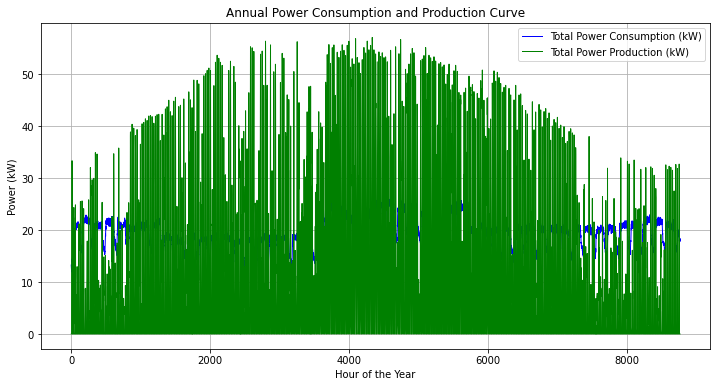

In [23]:
# Compute total power in kW
test_consumption["Total_Power_kW"] = test_consumption.sum(axis=1) / 1000
test_production["Total_Production_kW"] = test_production.sum(axis=1) / 1000

# Plot the total power consumption and production over the year in kW
plt.figure(figsize=(12, 6))
plt.plot(test_consumption.index, test_consumption["Total_Power_kW"], label="Total Power Consumption (kW)", linewidth=1, color='blue')
plt.plot(test_production.index, test_production["Total_Production_kW"], label="Total Power Production (kW)", linewidth=1, color='green')

# Labels and title
plt.xlabel("Hour of the Year")
plt.ylabel("Power (kW)")
plt.title("Annual Power Consumption and Production Curve")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [24]:
test_consumption

,w298890331,w472420804,w473457215,w475959205,w475960231,w476748191,w477684043,w478158110,w482663211,w482663212,...,w839482158,w881941844,w884214063,w891199681,w896947029,w898628582,w900520092,w901800611,w1208680335,Total_Power_kW
0,327.684676,361.668145,251.061228,225.499976,185.888556,840.384504,328.134776,593.758666,221.856119,242.112122,...,36.007453,307.311538,162.962329,380.162423,222.133929,230.204284,249.585186,98.710598,195.813008,13.254973
1,297.890908,305.864027,248.739561,211.374087,215.904625,903.120402,289.897894,539.717110,230.258365,195.410201,...,45.231225,274.058764,171.124490,413.653013,212.394598,297.699223,273.008194,108.674643,189.856858,12.896232
2,330.204671,228.250489,280.148288,256.191286,139.150191,874.653432,264.123927,667.549188,214.024652,220.054709,...,41.331038,273.978933,185.876532,345.276718,190.910785,235.113098,238.738537,104.121337,176.585993,12.486663
3,273.805898,332.119731,274.886453,190.122981,186.146366,857.929353,276.189976,629.609713,191.132106,220.665329,...,44.077797,317.605552,176.533355,293.191567,196.850669,243.847760,246.324055,102.696216,174.094016,12.148557
4,285.702763,333.771373,276.803044,229.586197,183.168895,832.389756,269.929209,505.654489,198.372192,209.805942,...,33.265831,294.450190,170.032236,330.353721,212.817730,247.693153,224.862442,80.548823,183.787253,12.050063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,569.562463,425.428928,392.701603,324.773558,292.513579,1086.134695,393.884331,798.912193,318.485125,274.465006,...,61.673995,365.788962,207.942315,513.141501,338.823922,451.361375,381.472470,167.644624,281.645538,18.269661
8756,399.453097,433.502673,382.010502,380.996538,271.880970,999.988850,399.005484,888.476837,271.597999,338.554121,...,67.019775,409.269435,208.113331,672.581308,289.761150,362.975977,331.922433,158.048193,245.205892,18.047321
8757,420.840978,335.728216,391.380006,337.488300,246.738974,1090.313471,338.500287,809.260431,275.473114,397.260490,...,64.707205,389.201096,266.772920,451.916694,290.319671,467.824774,341.877230,167.160242,266.175762,17.784341
8758,454.391087,457.690971,438.103220,322.260552,289.577715,1160.209138,312.577374,958.606389,265.577802,323.749768,...,71.764935,398.938780,256.832946,556.576035,301.015991,403.630350,345.488641,142.247759,275.959013,18.364405


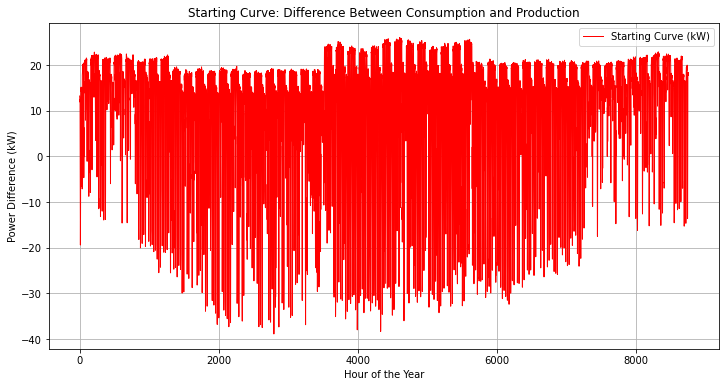

In [25]:
# Create the "Starting Curve" table
starting_curve_df = pd.DataFrame()
starting_curve_df["Starting Curve"] = test_consumption["Total_Power_kW"] - test_production["Total_Production_kW"]

# Save the table to a CSV file
starting_curve_df.to_csv(os.path.join(results_dir, 'Starting_Curve.csv'), index=False)

# Plot the "Starting Curve"
plt.figure(figsize=(12, 6))
plt.plot(starting_curve_df.index, starting_curve_df["Starting Curve"], label="Starting Curve (kW)", linewidth=1, color='red')

# Labels and title
plt.xlabel("Hour of the Year")
plt.ylabel("Power Difference (kW)")
plt.title("Starting Curve: Difference Between Consumption and Production")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [26]:
# Get the list of user IDs (assuming they are in columns)
user_ids = list(Residential_user_Consumption.columns[1:])  # Exclude the time index column

# Get number of hours (rows) and number of users (columns)
num_hours = len(starting_curve_df)
num_users = len(user_ids)

# Create the Gurobi model
model = gp.Model("User_Selection_Optimization")

# Create binary decision variables
binary_vars_consumption_residential = model.addVars(
    user_ids, vtype=GRB.BINARY, name="SelectUser"
)

# Auxiliary variables to represent the absolute differences
abs_diff = model.addVars(
    num_hours, vtype=GRB.CONTINUOUS, name="AbsoluteDifference"
)

# Objective function: minimize the absolute difference
model.setObjective(gp.quicksum(abs_diff[t] for t in range(num_hours)), GRB.MINIMIZE)

# Constraints: Calculate the absolute difference for each hour
for t in range(num_hours):
    selected_consumption = gp.quicksum(
        Residential_user_Consumption.iloc[t, i+1] * binary_vars_consumption_residential[user_ids[i]]
        for i in range(num_users)
    )
    
    model.addConstr(abs_diff[t] >= starting_curve_df.iloc[t, 0] - selected_consumption, f"PosDiff_{t}")
    model.addConstr(abs_diff[t] >= selected_consumption - starting_curve_df.iloc[t, 0], f"NegDiff_{t}")


# Set solver parameters
model.Params.MIPGap = 0.1

# Optimize the model
model.optimize()

# Extract the selected users
selected_users = [user for user in user_ids if binary_vars_consumption_residential[user].x > 0.5]
print("Selected Residential Users:", selected_users)


KeyboardInterrupt: 